#Proposed Model: COLAB NOTEBOOK (CODE)
MD FAIZAN SHAKEEL (19EEB201)
SHAMROZ QUADIR (19EEB136)
Z.H. COllege of Engineering & Technology ALIGARH MUSLIM UNIVERSITY

In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import cv2


import math
import random


import xml.etree.ElementTree as ET
from natsort import natsorted
import requests
from zipfile import ZipFile
from io import BytesIO
from six.moves import xrange
import collections
import string

### Fuctions for preprocessing the data

In [ ]:
#F1: Creating Df(structured) from XML and Jpeg 

def Create_dataframe(path):
    dirs=natsorted(os.listdir(path))
    xml_list=[]
    img_list=[]
    for i in range(len(dirs)):
        if '.xml' in dirs[i]:
            xml_list.append(dirs[i])
        if not '.xml'  in dirs[i]:
            img_list.append(dirs[i])
    xml_list=natsorted(xml_list)
    img_list=natsorted(img_list)
    tirads=[]
    for j in range(len(xml_list)):
        tree = ET.parse(path+'/'+xml_list[j])
        a=tree.findall("./tirads")
        if a[-1].text!=None:
            case=[xml_list[j],a[-1].text]
            tirads.append(case)
    data=[]
    for k in range(len(tirads)):
        xml=tirads[k][0][:-4]
        for z in range(len(img_list)):
            if xml+'_1.jpg'==img_list[z] or xml+'_2.jpg'==img_list[z] or xml+'_3.jpg'==img_list[z]:
                m=[img_list[z],tirads[k][1]]
                data.append(m)

    df = pd.DataFrame(data,columns =['Jpeg_Name', 'Tirads'])
    return df

In [ ]:
#F2: Cropp Function

def croping(img,x, y, w, h):
    if abs(w)<abs(h):
        img2=np.zeros([h,h])
        img2[:,h-w:h]=img[y:y+h, x:x+w]
    if abs(h)<abs(w):  
        img2=np.zeros([w,w])
        img2[w-h:w,:]=img[y:y+h, x:x+w]
    else:
        return img
    return img2


In [ ]:
#F3:  Convert RGB to grayscale, If some Images are colour 

def convert_one_channel(img):
    #if some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

In [ ]:
#F4:Remove Fill area from Image and Resizeing
#Calling F3 and F2
#used CV2 

def crop_resize(path,resize_shape):
    img=plt.imread(path)
    img=convert_one_channel(np.asarray(img))        
    kernel =( np.ones((5,5), dtype=np.float32))
    ret,thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    thresh = thresh.astype(np.uint8)
    a1,b1=thresh.shape
    thresh=cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel,iterations=3 )
    thresh=cv2.erode(thresh,kernel,iterations =5)
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c_area=np.zeros([len(contours)])
    for i in range(len(contours)):
        c_area[i]= cv2.contourArea(contours[i]) 
    cnts=contours[np.argmax(c_area)]    
    x, y, w, h = cv2.boundingRect(cnts)
    roi = croping(img, x, y, w, h)                 #F2
    roi=cv2.resize(roi,(resize_shape),interpolation=cv2.INTER_LANCZOS4)
    return roi

In [ ]:
#F5: TO Data Matrix
#Calling F4

def to_imgmatrix(resize_shape,path,df):
    path=path+'/'  
    images=crop_resize(path+df["Jpeg_Name"][0],resize_shape)
    for i in range (1,len(df["Jpeg_Name"])):
        img=crop_resize(path+df["Jpeg_Name"][i],resize_shape)
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(df["Jpeg_Name"]),resize_shape[0],resize_shape[1],1))
    return images

In [ ]:
#F6: Prepare_date for train (final Touch)
#Calling F1 and F5

def prepare_data(path,resize_shape):
    df=Create_dataframe(path)
    data=to_imgmatrix(resize_shape,path,df) 
    return df, data

# Loading and preprocessing data

In [ ]:
df,data = prepare_data('/content/drive/MyDrive/Final Year Project/TDID_DATASET_FYPROJECT', (256,256))

In [ ]:
df[:3]

,Jpeg_Name,Tirads
0,2_1.jpg,2
1,3_1.jpg,4a
2,4_1.jpg,4a


In [ ]:
# We need numeric category
#There are little categories, so i handled manually
#only 6 categories(0 to 5):  1 (Benign) | 2 (Benign) | 4a (Malign) | 4b (Malign) | 4c (Malign) | 5 (Malign)

def to_categoricalmatrix(df):
    Y=np.zeros([len(df["Tirads"])])
    for i in range(len(df["Tirads"])):
        if df["Tirads"][i]=="2":
          Y[i]=0
        if df["Tirads"][i]=="3":
          Y[i]=1
        if df["Tirads"][i]=="4a":
          Y[i]=2
        if df["Tirads"][i]=="4b":
          Y[i]=3
        if df["Tirads"][i]=="4c":
          Y[i]=4
        if df["Tirads"][i]=="5":
          Y[i]=5
    return Y

In [ ]:
# 1,2,4a,4b,4c,5 to integer 

y=to_categoricalmatrix(df) # df causing error so providing  df[0] | we can also use df1
y[:8] 

array([0., 2., 2., 5., 3., 2., 4., 3.])

In [ ]:
#  tf.keras.utils.to_categorical  : Converts a class vector (integers) to binary class matrix.
# Each image corrosponds to vector of size 6

y=tf.keras.utils.to_categorical(y, dtype='float32')
y[:8] 

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

## Before Training Our Model we also need to normalize to the images :

In [ ]:
#Image Normalization: Enhancing Data Consistency and Quality
#Department of Electrical Engineering Aligarh Muslim University, India.
def normalize(data):
  for i in range(len(data)):
    data[i,:,:,:]=data[i,:,:,:]*(1/np.max(data[i,:,:,:]))
  return np.float32(data)
  
#images are stored in 'Data'
X=normalize(data)

#Checking
X[300:303]

NameError: ignored

### Train Test and Validation split

In [ ]:
X_train = np.copy(X[:300,:,:,:])
X_test = np.copy(X[313:,:,:,:])
X_val = np.copy(X[300:313,:,:,:])


y_train = np.copy(y[:300,:])
y_test = np.copy(y[313:,:])
y_val = np.copy(y[300:313,:])

## Pre-processing: Data Augmentation:

In [ ]:
#Data Augmention for to prevent Overfitting and to improve accuracy

from tensorflow.keras import layers

data_augmentation1 = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal"),
 layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.2),fill_mode="constant"),
 layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.2),fill_mode="constant"),
 tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)])



#Now creating New set of training data by (concatinating augmented data)

X_train1=data_augmentation1(X_train)
y_train1=np.copy(y_train)

i=1
#22
while(i<22):
  X_aug=data_augmentation1(X)
  X_train1=np.concatenate((X_train1,X_aug),axis=0)
  y_aug=np.copy(y)
  y_train1=np.concatenate((y_train1,y_aug))

  #20
  if i == 20:
    break
  i += 1

In [ ]:
X_train1.shape

(7240, 256, 256, 1)

# Creating Model: EfficentNetB1

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1

# Load the pre-trained EfficientNetB1 model
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
f=tf.keras.layers.Flatten(name="flatten")(x)

#To prevent overfitting and unbalancing , used regularizer

d2=tf.keras.layers.Dense(1024,activation="relu",kernel_regularizer=tf.keras.regularizers.l1_l2(0.00001))(f)
dp9=tf.keras.layers.Dropout(0.5)(d2)
d3=tf.keras.layers.Dense(1024,activation="relu")(f)
dp10=tf.keras.layers.Dropout(0.5)(d2)

final=tf.keras.layers.Dense(6,activation="softmax")(dp10)

model = tf.keras.Model( inputs =[ base_model.input], outputs = final)

27018416/27018416 [==============================] - 0s 0us/step


In [ ]:
metrics = tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC',
    summation_method='interpolation'
)

#categorical_crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=metrics)

def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 15
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

#after each 15 epochs , we want to decrease learning rate for converge to model
lr_call = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
epochs=35

history=model.fit(x=[X_train1],y=[y_train1],batch_size=16,epochs=epochs,callbacks=[lr_call],validation_data=(X_val,y_val))

Epoch 1/35
453/453 [==============================] - 191s 275ms/step - loss: 1.0547 - auc_1: 0.9971 - val_loss: 12338.7695 - val_auc_1: 0.4923 - lr: 1.0000e-04
Epoch 2/35
453/453 [==============================] - 124s 273ms/step - loss: 1.3284 - auc_1: 0.9978 - val_loss: 3.1712 - val_auc_1: 0.7118 - lr: 1.0000e-04
Epoch 3/35
453/453 [==============================] - 125s 275ms/step - loss: 1.0338 - auc_1: 0.9985 - val_loss: 28203.7988 - val_auc_1: 0.5385 - lr: 1.0000e-04
Epoch 4/35
453/453 [==============================] - 125s 276ms/step - loss: 1.2584 - auc_1: 0.9980 - val_loss: 99908.2344 - val_auc_1: 0.4923 - lr: 1.0000e-04
Epoch 5/35
453/453 [==============================] - 125s 276ms/step - loss: 1.4591 - auc_1: 0.9969 - val_loss: 4.1809 - val_auc_1: 0.6355 - lr: 1.0000e-04
Epoch 6/35
453/453 [==============================] - 125s 276ms/step - loss: 1.0561 - auc_1: 0.9987 - val_loss: 3.2057 - val_auc_1: 0.6231 - lr: 1.0000e-04
Epoch 7/35
453/453 [==========================

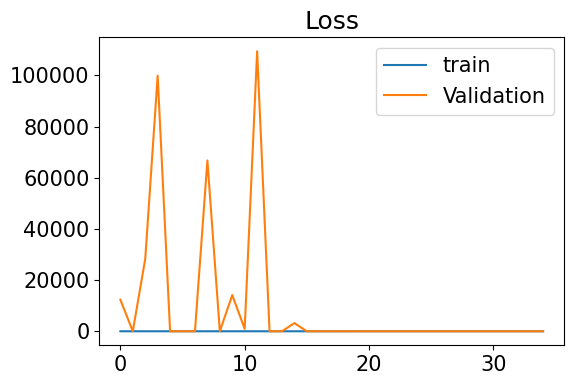

In [ ]:
# Lets see our validation and training loss .

plt.figure(figsize = (6,4))
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()

In [ ]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 34ms/step - loss: 0.0187 - auc_1: 1.0000


[0.01867709308862686, 1.0]

In [ ]:
# Save the model architecture as JSON
#model.summary()

In [ ]:
#Prediction and Checking
y_pred= model.predict(X_test)
y_pred

2/2 [==============================] - 0s 121ms/step


array([[1.10223430e-12, 5.27681902e-13, 2.53608050e-12, 1.00000000e+00,
        8.52589050e-13, 4.81165997e-13],
       [9.99998212e-01, 4.81574261e-07, 4.15595338e-07, 5.42228236e-07,
        1.55516872e-07, 2.37522158e-07],
       [4.89124541e-05, 1.01424803e-05, 3.43010652e-05, 7.61041665e-05,
        9.99762952e-01, 6.75833726e-05],
       [3.88568927e-10, 4.06767314e-10, 8.38135505e-10, 2.11163487e-09,
        1.00000000e+00, 2.02250217e-09],
       [9.41714371e-13, 1.81252409e-12, 1.04333567e-12, 8.88214936e-12,
        1.00000000e+00, 3.16446131e-12],
       [7.29876660e-07, 2.33561963e-07, 1.68528902e-06, 9.99995112e-01,
        1.03031448e-06, 1.18648074e-06],
       [6.34316066e-08, 9.99999523e-01, 1.52312879e-07, 5.53735333e-08,
        3.07817665e-08, 6.40728999e-08],
       [6.30124305e-07, 9.99994040e-01, 1.99154374e-06, 1.66729956e-06,
        4.46830114e-07, 1.21599987e-06],
       [2.24215720e-14, 3.51684586e-15, 8.01934135e-14, 3.12882776e-13,
        7.93535647e-13, 

In [ ]:
# len(y_pred): 34   0
Predictions = []
for i in range(34):
  x= np.argmax(y_pred[i])
  Predictions.append(x)

print(Predictions)

[3, 0, 4, 4, 4, 3, 1, 1, 5, 1, 1, 0, 0, 4, 1, 4, 4, 1, 4, 2, 0, 4, 4, 4, 0, 0, 4, 5, 2, 2, 0, 3, 3, 2]


#Evaluating sensitivity , specificity and accuracy

In [ ]:
# Make predictions on the test dataset
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_classes = tf.argmax(y_pred, axis=1)
y_test_classes = tf.argmax(y_test, axis=1)

# Calculate True Positives, False Positives, True Negatives, and False Negatives
TP = tf.keras.metrics.TruePositives()
TP.update_state(y_test_classes, y_pred_classes)

FP = tf.keras.metrics.FalsePositives()
FP.update_state(y_test_classes, y_pred_classes)

TN = tf.keras.metrics.TrueNegatives()
TN.update_state(y_test_classes, y_pred_classes)

FN = tf.keras.metrics.FalseNegatives()
FN.update_state(y_test_classes, y_pred_classes)

# Calculate sensitivity (True Positive Rate)
sensitivity = TP.result() / (TP.result() + FN.result())

# Calculate specificity (True Negative Rate)
specificity = TN.result() / (TN.result() + FP.result())

# Calculate accuracy
accuracy = (TP.result() + TN.result()) / (TP.result() + FP.result() + TN.result() + FN.result())

print("Sensitivity:", sensitivity.numpy())
print("Specificity:", specificity.numpy())
print("Accuracy:", accuracy.numpy())

2/2 [==============================] - 0s 121ms/step
Sensitivity: 1.0
Specificity: 1.0
Accuracy: 1.0


# ROC curve
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters [developers.google]

No Skill: ROC AUC=0.500
Model: ROC AUC=1.000


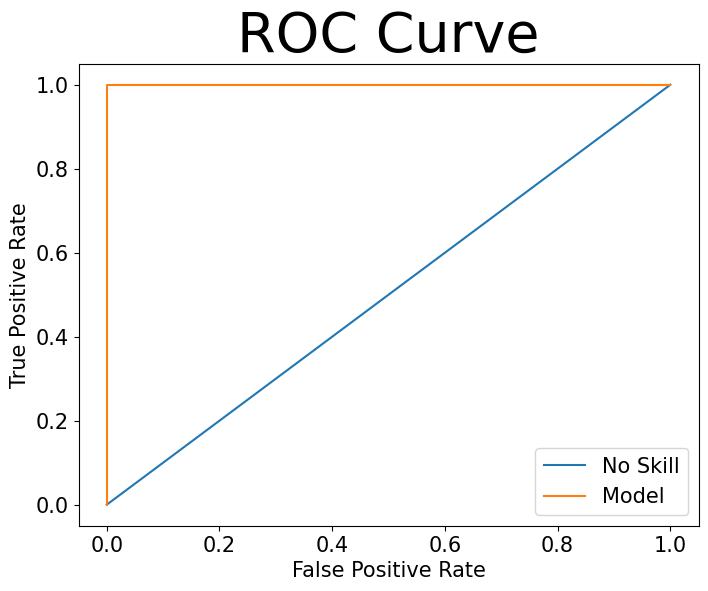

In [ ]:
#Next ROC Curve :

y_test=np.reshape(y_test,(34*6))
predict=np.reshape(y_pred,(34*6))
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# keep probabilities for the positive outcome only
ns_probs = [0 for _ in range(len(y_test))]


# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, predict)


# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))


# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, predict)


# plot the roc curve for the model
plt.figure(figsize = (8,6))
plt.title("ROC Curve",fontsize = 40)
plt.plot(ns_fpr, ns_tpr,label='No Skill')
plt.plot(lr_fpr, lr_tpr, label='Model')


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.rcParams["font.size"] = "15"

# show the legend
plt.legend()

# show the plot
plt.show()